In [1]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import numpy.random as npr

import matplotlib
from matplotlib import pyplot as plt

# Comment these lines if your MPC is in the current directory.
# Otherwise modify to the directory.
import sys
sys.path.append('./../mpc.pytorch/')


from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
from mpc.dynamics import NNDynamics
import mpc.util as eutil
from mpc.env_dx import pendulum, cartpole, frenet_kin_bicycle
from mpc.track.src import simple_track_generator, track_functions


#import sys
#from IPython.core import ultratb
#sys.excepthook = ultratb.FormattedTB(mode='Verbose',
#     color_scheme='Linux', call_pdb=1)

import time
import os
import shutil
import pickle as pkl
import collections

import argparse

from tqdm import tqdm

In [2]:
class NN(nn.Module):
    def __init__(self, H):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(H + 6, 128)  
        self.fc2 = nn.Linear(128, 64)  
        self.output1 = nn.Linear(64, 6) 
        self.output2 = nn.Linear(64, 6) 

    def forward(self, c, x0):
        combined = torch.cat((c, x0), dim=1)
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        q = F.relu(self.output1(x)) + 0.3
        p = self.output2(x)
        return q, p

In [3]:
# Let's try to create a track 

track_density = 300
track_width = 0.5
gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'LONG_TRACK'

In [4]:
t = 0.3
init = [0,0,0]

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)
    
track_function(gen, t, init)
    
gen.populatePointsAndArcLength()
gen.centerTrack()

track_coord = torch.from_numpy(np.vstack([gen.xCoords, gen.yCoords, gen.arcLength, gen.tangentAngle, gen.curvature]))

In [5]:
device = 'cpu'

def sample_xinit(n_batch):
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 0.2)
    d = uniform(n_batch, -0.1, 0.1)
    phi = uniform(n_batch, -0.10*np.pi, 0.10*np.pi)
    v = uniform(n_batch, 0., 0.5)
    d_lb = softplus_op(-d-0.5*track_width)
    d_ub = softplus_op(d-0.5*track_width)
    xinit = torch.stack((sigma, d, phi, v, d_lb, d_ub), dim=1)
    return xinit


true_dx = frenet_kin_bicycle.FrenetKinBicycleDx(track_coord)
mpc_T = 15
n_batch = 8
H_curve = 60
use_NN_curv = False

# Added here the bounds of U
u_lower = torch.tensor([-2., -0.4]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_upper = torch.tensor([2., 0.4]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_init= torch.tensor([0.0, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)


n_state = true_dx.n_state
n_ctrl = true_dx.n_ctrl

eps = 1e-2
lqr_iter = 60
grad_method = GradMethods.AUTO_DIFF

softplus_op = torch.nn.Softplus(10)

In [6]:
def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

In [7]:
def get_loss_progress(x_init, dx, _Q, _p, mpc_T=mpc_T):    
        
        pred_x, pred_u, pred_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_lower=u_lower, u_upper=u_upper, u_init=u_init,
            lqr_iter=60,
            verbose=0,
            exit_unconverged=False,
            detach_unconverged=True,
            linesearch_decay=0.1,
            max_linesearch_iter=10,
            grad_method=grad_method,
            eps=0.5,
            n_batch=n_batch,
        )(x_init, QuadCost(_Q, _p), dx)
        
        progress_loss = torch.mean(-pred_x[mpc_T-1,:,0] + pred_x[0,:,0])
            
        return progress_loss

In [8]:
env_params = true_dx.params
track_coord = track_coord.to(device)
dx = true_dx.__class__(track_coord,env_params)

q_penalty = .001*torch.ones(2).to(device)
p_penalty = 1.*torch.ones(2).to(device)

In [9]:
if use_NN_curv:
    model = NN(H_curve)
    opt = optim.Adam(model.parameters(), lr=5e-4)
    q_penalty_batch = q_penalty.unsqueeze(0).repeat(n_batch,1)
    p_penalty_batch = p_penalty.unsqueeze(0).repeat(n_batch,1)
else:
    true_q, true_p = true_dx.get_true_obj()
    params1 = []
    learn_q_logit_state = torch.ones(n_state-2, requires_grad=True).to(device)
    learn_q_logit_input = torch.ones(n_ctrl, requires_grad=True).to(device)
    learn_p_state = torch.zeros(n_state-2, requires_grad=True).to(device)
    learn_p_input = torch.zeros(n_ctrl, requires_grad=True).to(device)
    params1 += [learn_q_logit_state, learn_q_logit_input, learn_p_state, learn_p_input]
    params = [{
                'params': params1,
                'lr': 2e-3,
                'alpha': 0.99,
                }]
    opt = optim.RMSprop(params)

In [10]:
def get_curve_hor_from_x(x, track_coord, mpc_T):
    idx_track_batch = ((x[:,0]-track_coord[[2],:].T)**2).argmin(0)
    idcs_track_batch = idx_track_batch[:, None] + torch.arange(mpc_T)
    curvs = track_coord[4,idcs_track_batch].float()
    return curvs

In [11]:
def cost_to_batch_NN(q, p, n_batch, mpc_T):
    Q_batch = torch.zeros(n_batch, q.shape[1], q.shape[1])
    rows, cols = torch.arange(q.shape[1]), torch.arange(q.shape[1])  
    Q_batch[:, rows, cols] = q 
    Q_batch = Q_batch.unsqueeze(0).repeat(
                mpc_T, 1, 1, 1)    
    p_batch = p.unsqueeze(0).repeat(mpc_T, 1, 1)
    return Q_batch, p_batch

def cost_to_batch(q, p, n_batch, mpc_T):
    Q_batch = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
                mpc_T, n_batch, 1, 1
            )
    p_batch = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)   
    return Q_batch, p_batch

In [15]:
for i in range(500):
    
    x_init = sample_xinit(n_batch).to(device)
    
    if use_NN_curv:
        curvs = get_curve_hor_from_x(x_init, track_coord, H_curve)
        q_learned, p_learned = model(curvs, x_init)
        q = torch.cat((q_learned, q_penalty_batch), dim=1)
        p = torch.cat((p_learned, p_penalty_batch), dim=1)
        q[:,1] = q[:,1] + 20.0
        Q_batch, p_batch = cost_to_batch_NN(q, p, n_batch, mpc_T)
    
    else:
        q = torch.cat((learn_q_logit_state,learn_q_logit_input,q_penalty),dim=0)
        p = torch.cat((learn_p_state,learn_p_input,p_penalty), dim=0)  
        q = q.clip(0.0001)
        q[1] = q[1] + 20.0
        Q_batch, p_batch = cost_to_batch(q, p, n_batch, mpc_T)
        #print(q)   
        
    loss = get_loss_progress(x_init, dx, Q_batch, p_batch)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print('Batch:', i , ' Progression with MPC_T=',mpc_T ,': ', -round(loss.item(), 4))

Batch: 0  Progression with MPC_T= 15 :  -0.2934
Batch: 1  Progression with MPC_T= 15 :  -0.3015
Batch: 2  Progression with MPC_T= 15 :  -0.2535
Batch: 3  Progression with MPC_T= 15 :  -0.2812
Batch: 4  Progression with MPC_T= 15 :  -0.2719
Batch: 5  Progression with MPC_T= 15 :  -0.2802
Batch: 6  Progression with MPC_T= 15 :  -0.2785
Batch: 7  Progression with MPC_T= 15 :  -0.2595
Batch: 8  Progression with MPC_T= 15 :  -0.2612
Batch: 9  Progression with MPC_T= 15 :  -0.3008
Batch: 10  Progression with MPC_T= 15 :  -0.2706
Batch: 11  Progression with MPC_T= 15 :  -0.2752
Batch: 12  Progression with MPC_T= 15 :  -0.2399
Batch: 13  Progression with MPC_T= 15 :  -0.2841
Batch: 14  Progression with MPC_T= 15 :  -0.2453
Batch: 15  Progression with MPC_T= 15 :  -0.2935
Batch: 16  Progression with MPC_T= 15 :  -0.221
Batch: 17  Progression with MPC_T= 15 :  -0.3015
Batch: 18  Progression with MPC_T= 15 :  -0.2284
Batch: 19  Progression with MPC_T= 15 :  -0.3045
Batch: 20  Progression with MPC

Batch: 167  Progression with MPC_T= 15 :  -0.319
Batch: 168  Progression with MPC_T= 15 :  -0.2637
Batch: 169  Progression with MPC_T= 15 :  -0.3071
Batch: 170  Progression with MPC_T= 15 :  -0.278
Batch: 171  Progression with MPC_T= 15 :  -0.277
Batch: 172  Progression with MPC_T= 15 :  -0.2136
Batch: 173  Progression with MPC_T= 15 :  -0.2869
Batch: 174  Progression with MPC_T= 15 :  -0.2541
Batch: 175  Progression with MPC_T= 15 :  -0.2597
Batch: 176  Progression with MPC_T= 15 :  -0.3481
Batch: 177  Progression with MPC_T= 15 :  -0.2837
Batch: 178  Progression with MPC_T= 15 :  -0.2262
Batch: 179  Progression with MPC_T= 15 :  -0.2495
Batch: 180  Progression with MPC_T= 15 :  -0.3377
Batch: 181  Progression with MPC_T= 15 :  -0.1824
Batch: 182  Progression with MPC_T= 15 :  -0.2749
Batch: 183  Progression with MPC_T= 15 :  -0.2878
Batch: 184  Progression with MPC_T= 15 :  -0.2545
Batch: 185  Progression with MPC_T= 15 :  -0.344
Batch: 186  Progression with MPC_T= 15 :  -0.2905
Batc

Batch: 332  Progression with MPC_T= 15 :  -0.2231
Batch: 333  Progression with MPC_T= 15 :  -0.3265
Batch: 334  Progression with MPC_T= 15 :  -0.2819
Batch: 335  Progression with MPC_T= 15 :  -0.2514
Batch: 336  Progression with MPC_T= 15 :  -0.3001
Batch: 337  Progression with MPC_T= 15 :  -0.2541
Batch: 338  Progression with MPC_T= 15 :  -0.3286
Batch: 339  Progression with MPC_T= 15 :  -0.3072
Batch: 340  Progression with MPC_T= 15 :  -0.2773
Batch: 341  Progression with MPC_T= 15 :  -0.2805
Batch: 342  Progression with MPC_T= 15 :  -0.2788
Batch: 343  Progression with MPC_T= 15 :  -0.2394
Batch: 344  Progression with MPC_T= 15 :  -0.27
Batch: 345  Progression with MPC_T= 15 :  -0.2588
Batch: 346  Progression with MPC_T= 15 :  -0.298
Batch: 347  Progression with MPC_T= 15 :  -0.2553
Batch: 348  Progression with MPC_T= 15 :  -0.2748
Batch: 349  Progression with MPC_T= 15 :  -0.253
Batch: 350  Progression with MPC_T= 15 :  -0.232
Batch: 351  Progression with MPC_T= 15 :  -0.2862
Batch

Batch: 497  Progression with MPC_T= 15 :  -0.2634
Batch: 498  Progression with MPC_T= 15 :  -0.2945
Batch: 499  Progression with MPC_T= 15 :  -0.3255


In [ ]:
N_test = 1
mpc_T_test = 15

In [ ]:
x_init_test = sample_xinit(N_test)

In [15]:
x_init_test

tensor([[ 0.0650, -0.0073,  0.0254,  1.3689,  0.0085,  0.0073]])

In [16]:
# Below you can put any initial state you want (any that make sense)
d = torch.tensor(0.0)
d_lb = softplus_op(-d-0.5*track_width)
d_ub = softplus_op(d-0.5*track_width)

x_init_test = torch.tensor([[0.01, d, -.0, 0.01, d_lb, d_ub]])

In [17]:
# Added here the bounds of U
u_lower_test = torch.tensor([-2., -.4]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_upper_test = torch.tensor([2., .4]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_init= torch.tensor([0.0, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)

In [18]:
q_penalty.shape

torch.Size([2])

In [19]:
N_sim_total = 100
x_simulated = torch.zeros((N_sim_total,1,6))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):
      
    
    x_sim = x_simulated[i-1]
    print(x_sim)
        
    if use_NN_curv:
        curvs_test = get_curve_hor_from_x(x_sim, track_coord, H_curve)
        q_test, p_test = model(curvs_test, x_sim)
        q_test = torch.cat((q_test, q_penalty_batch), dim=1)
        p_test = torch.cat((p_test, p_penalty_batch), dim=1)
        q_test[:,1] = q_test[:,1] + 20.0
        Q_test_batch, p_test_batch = cost_to_batch_NN(q_test, p_test, N_test, mpc_T_test) 
    
    else:
        q_test = torch.cat((learn_q_logit_state,learn_q_logit_input,q_penalty),dim=0)
        p_test = torch.cat((learn_p_state,learn_p_input,p_penalty), dim=0) 
        q_test = q_test.clip(0.0001)
        q_test[1] = q_test[1] + 100.0
        Q_test_batch, p_test_batch = cost_to_batch(q_test, p_test, N_test, mpc_T_test)
            
 
    x_mpc_test, u_mpc_test, objs_mpc_test = mpc.MPC(
                n_state, n_ctrl, mpc_T_test,
                u_lower=u_lower_test, u_upper=u_upper_test, u_init=u_init,
                lqr_iter=60,
                verbose=0,
                exit_unconverged=False,
                detach_unconverged=True,
                linesearch_decay=.4,
                max_linesearch_iter=10,
                grad_method=grad_method,
                eps=.5,
                n_batch=N_test,
            )(x_sim, QuadCost(Q_test_batch, p_test_batch), dx)
    #print(x_mpc_test[1])
    x_simulated[i] = x_mpc_test[1]

tensor([[0.0100, 0.0000, -0.0000, 0.0100, 0.0079, 0.0079]])
tensor([[ 0.0105, -0.0104, -0.0005, -0.0900,  0.0087,  0.0071]],
       grad_fn=<SelectBackward0>)
tensor([[ 0.0061, -0.0208,  0.0041, -0.1900,  0.0096,  0.0065]],
       grad_fn=<SelectBackward0>)
tensor([[-0.0032, -0.0313,  0.0140, -0.2900,  0.0106,  0.0058]],
       grad_fn=<SelectBackward0>)
tensor([[-0.0174, -0.0419,  0.0290, -0.3900,  0.0118,  0.0053]],
       grad_fn=<SelectBackward0>)
tensor([[-0.0366, -0.0529,  0.0491, -0.4900,  0.0130,  0.0047]],
       grad_fn=<SelectBackward0>)
tensor([[-0.0610, -0.0624,  0.0694, -0.5900,  0.0143,  0.0043]],
       grad_fn=<SelectBackward0>)
tensor([[-0.0904, -0.0718,  0.0910, -0.6900,  0.0156,  0.0039]],
       grad_fn=<SelectBackward0>)
tensor([[-0.1233, -0.0645,  0.0554, -0.7900,  0.0145,  0.0042]],
       grad_fn=<SelectBackward0>)
tensor([[-0.1615, -0.0563,  0.0146, -0.8900,  0.0135,  0.0046]],
       grad_fn=<SelectBackward0>)
tensor([[-0.2059, -0.0549,  0.0053, -0.9900,  0.0

KeyboardInterrupt: 

In [24]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

In [25]:
x_plot = np.array(x_list)
y_plot = np.array(y_list)

In [26]:
u_mpc_test.max(0)[0].max(0)[0]

tensor([2.0000, 0.4000], grad_fn=<MaxBackward0>)

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


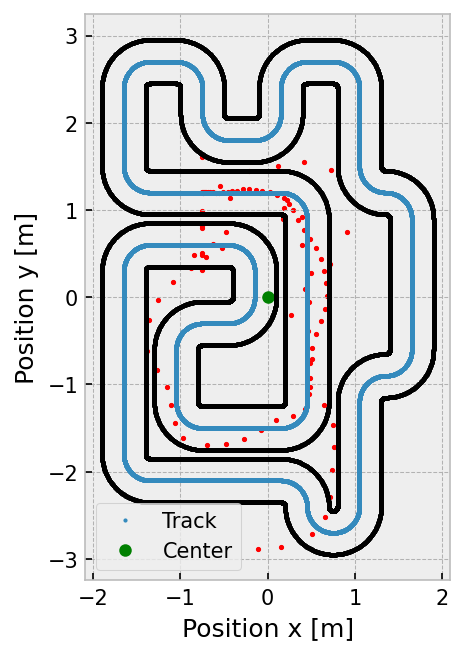

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

ax.scatter(x_plot, y_plot, s=4, color='red')
#ax.scatter(0.1471, 0.8741, s=7, color='green')
#ax.scatter(0.4500, 0.5100, s=100, color='blue')



print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()